In [21]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re
import os.path
import os

interesting_keys = ['episode_reward_mean', "episode_len_mean", 'episodes_total', 'custom_metrics/inv', "time_this_iter_s", 'custom_metrics/accept']
hist_keys = ["inv", "accept"]


def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 0}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    events = ea.Scalars("ray/tune/episode_reward_mean")
    ids = [x.step for x in events]
    ids_s = set(x.step for x in events)
    df['step'] = ids
    walltimes = [x.wall_time for x in events]
    df['walltime'] = walltimes
    df['totalwalltime'] = walltimes[-1] - walltimes[0]
    df.set_index('step', inplace=True)
    for tag in hist_keys:
        fulltag = 'ray/tune/hist_stats/' + tag
        events = ea.Histograms(fulltag)
        indexes = [x.step for x in events if x.step in ids_s]
        mins = [x.histogram_value.min
                for x in events if x.step in ids_s]
        maxs = [x.histogram_value.max 
                for x in events if x.step in ids_s]
        means = [x.histogram_value.sum / x.histogram_value.num 
                 for x in events if x.step in ids_s]
        variances = [np.max((0, x.histogram_value.sum_squares / x.histogram_value.num - (x.histogram_value.sum / x.histogram_value.num)**2))
                     for x, mean in zip(events, means) if x.step in ids_s]
        stds = np.sqrt(variances)
        #print(events[-1].histogram_value)
        df.loc[indexes, tag+"_max"] = maxs
        df.loc[indexes, tag+"_min"] = mins
        df.loc[indexes, tag+"_mean"] = means
        df.loc[indexes, tag+"_std"] = stds
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        success = False
        for i in range(3):
            try:
                events = ea.Scalars(fultag)
            except KeyError:
                fultag+= "_mean"
            else:
                success = True
                break
        if not success:
            raise KeyError(fultag)

        scalars = np.array([x.value for x in events if x.step in ids_s])
        indexes = np.array([x.step for x in events if x.step in ids_s])
        df.loc[indexes, tag] = scalars

    df.reset_index(inplace=True)
    return df


def removeprefix(self: str, prefix: str, /) -> str:
    if self.startswith(prefix):
        return self[len(prefix):]
    else:
        return self[:]

In [42]:
nepisodes=200000
mainpath = f'logs/paperrun2/e{nepisodes}/cma/**/*tfevents*'
first, _ = mainpath.split("**")

shortname = ''.join(removeprefix(first, 'logs/').split('/'))
print(shortname)
figdir = "figures/" + shortname + "/"
os.makedirs(figdir, exist_ok=True)

paperrun2e200000cma


In [43]:
fuldfs = []
runid = 0
forcereload = False

if not forcereload and os.path.exists(first + "/sumup.df.pkl"):
    alldf = pd.read_pickle(first + "sumup.df.pkl")
else:
    for path in tqdm.tqdm(glob(mainpath, recursive=True)):
        try:
            curdf = create_df(path)
        except Exception as e:
            print(path)
            print(type(e), e)
        else:
            curdf['run'] = runid
            curdf['badsiteprob'] = float(re.search("good_site_prob=(.+),", path).group(1))
            curdf['trial_id'] = re.search(r"partner_choice_(.+)_(?:\d+)_good", path).group(1)
            fuldfs.append(curdf)
            runid += 1
    alldf = pd.concat(fuldfs)
    first, _ = mainpath.split("**")
    binsize = 1000
    mode = "ppo"
    if "cma" in mainpath: 
        mode = "cma"
    else:
        mode = "ppo"
    ps = [1, 0.5, 0.2, 0.1]
    if "true_episode_reward_mean" not in alldf.columns:
        alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
    if mode == "ppo": 
        alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
    if "p" not in alldf.columns:
        alldf["p"] = alldf["badsiteprob"]


    alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
    alldf = alldf.query("p in @ps").copy()
    alldf.to_pickle(first + "/sumup.df.pkl")


In [44]:
figwidth = 3.3

In [45]:
binsize = nepisodes//200
stepbin = alldf["step"].max() // 300
print(binsize)
print(stepbin)

if "cma" in mainpath: 
    mode = "cma"
else:
    mode = "ppo"
ps = [1, 0.5, 0.2, 0.1]
alldf = alldf.query("p in @ps").copy()

if "true_episode_reward_mean" not in alldf.columns:
    alldf["true_episode_reward_mean"] = alldf["episode_reward_mean"]
if mode == "ppo": 
    alldf["episode_reward_mean"] = alldf["true_episode_reward_mean"] / 2
if "p" not in alldf.columns:
    alldf["p"] = alldf["badsiteprob"]


alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )
alldf.to_pickle(first + "/sumup.df.pkl")

1000
481769


In [46]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('paper', font_scale=0.75)
sns.set_style("whitegrid")
figsize=(figwidth, figwidth/1.5)

In [47]:
alldf

,step,walltime,totalwalltime,inv_max,inv_min,inv_mean,inv_std,accept_max,accept_min,accept_mean,...,custom_metrics/inv,time_this_iter_s,custom_metrics/accept,run,badsiteprob,trial_id,true_episode_reward_mean,p,episode_bin_right,step_bin_right
0,16008,1.606537e+09,27067.867450,7.244868,7.244868,7.244868,0.0,6.5,0.0,1.25,...,7.244868,18.134201,1.25,0,0.5,2a035_00018,26.230284,0.5,1000.0,17000
1,25780,1.606537e+09,27067.867450,8.061890,8.061890,8.061890,0.0,8.0,6.5,7.50,...,8.061890,11.719351,7.50,0,0.5,2a035_00018,45.312416,0.5,1000.0,26000
2,36742,1.606537e+09,27067.867450,8.135495,8.135495,8.135495,0.0,8.0,8.0,8.00,...,8.135496,13.068075,8.00,0,0.5,2a035_00018,47.584335,0.5,1000.0,37000
3,47334,1.606537e+09,27067.867450,9.986555,9.986555,9.986555,0.0,9.5,7.0,8.25,...,9.986555,12.206178,8.25,0,0.5,2a035_00018,41.317135,0.5,1000.0,48000
4,60654,1.606537e+09,27067.867450,10.211767,10.211767,10.211767,0.0,10.0,8.0,8.75,...,10.211768,15.219946,8.75,0,0.5,2a035_00018,42.668743,0.5,1000.0,61000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,11773906,1.606536e+09,15289.565089,10.000000,10.000000,10.000000,0.0,10.0,10.0,10.00,...,10.000000,5.308066,10.00,95,1.0,4decc_00005,50.000000,1.0,200000.0,11774000
1996,11778830,1.606536e+09,15289.565089,10.000000,10.000000,10.000000,0.0,10.0,10.0,10.00,...,10.000000,5.175140,10.00,95,1.0,4decc_00005,45.000000,1.0,200000.0,11779000
1997,11784780,1.606536e+09,15289.565089,10.000000,10.000000,10.000000,0.0,10.0,10.0,10.00,...,10.000000,6.444609,10.00,95,1.0,4decc_00005,45.000000,1.0,200000.0,11785000
1998,11792784,1.606536e+09,15289.565089,10.000000,10.000000,10.000000,0.0,10.0,10.0,10.00,...,10.000000,8.143390,10.00,95,1.0,4decc_00005,50.000000,1.0,200000.0,11793000


In [48]:
from pandas.api.types import CategoricalDtype
ps = [1, 0.5, 0.2, 0.1]
step = False
epcollapsed = alldf.groupby(["p", "run", "episode_bin_right"], as_index=False).mean()
print("ep done")
if step:
    stepcollapsed = alldf[["p", "run", "step_bin_right", "inv_mean", "inv_std", "accept_mean"]].groupby(["p", "run", "step_bin_right"], as_index=False).mean()
    stepcollapsed["p"] = stepcollapsed["p"].astype(pcat)

print("step done")
pcat = CategoricalDtype(ps, ordered=True)
epcollapsed["p"] = epcollapsed["p"].astype(pcat)
print("p as cat done")
alldf["p"] = alldf["p"].astype(pcat)

ep done
step done
p as cat done


In [49]:
print("ok")
print(alldf.query("episode_bin_right >= @nepisodes").groupby("p")["run"].nunique())

ok
p
1.0    24
0.5    24
0.2    24
0.1    24
Name: run, dtype: int64


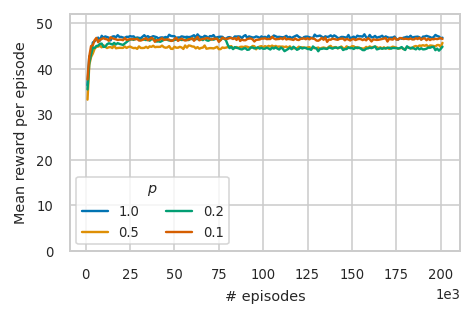

In [50]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
#sns.lineplot(
#    data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p",
#    estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
#)

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="p", ax=ax)

ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.ylim(0, 52)
plt.ylabel('Mean reward per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
plt.tight_layout()
plt.savefig(figdir + "reward_mean_synth.pdf")

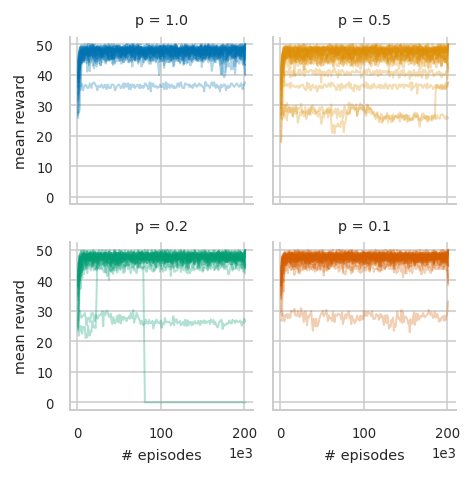

In [51]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/2), aspect=1, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean',
        estimator=None, alpha=0.3, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_reward_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.set_axis_labels("# episodes", "mean reward")
g.tight_layout()
g.savefig(figdir + "reward_mean_detail.pdf")

In [52]:
if step:
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    sns.lineplot(
            data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="p",
            estimator=None, linewidth=1, ax=ax, units="run"
        )
    ax.ticklabel_format(axis="x", scilimits=(6, 6))

    plt.ylim(0, 50)
    plt.ylabel('mean reward per episode')
    plt.xlabel('# step')
    plt.legend(ncol=2, title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "reward_mean_synth_step.pdf")

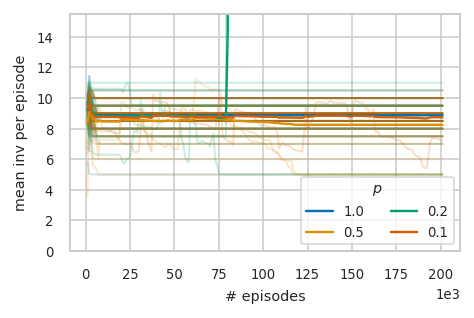

In [62]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv', hue="p", ax=ax)

plt.ylim(0, 15.5)
plt.ylabel('mean inv per episode')
plt.xlabel('# episodes')
plt.legend(ncol=2, title="$p$")
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "inv_mean_synth.pdf")

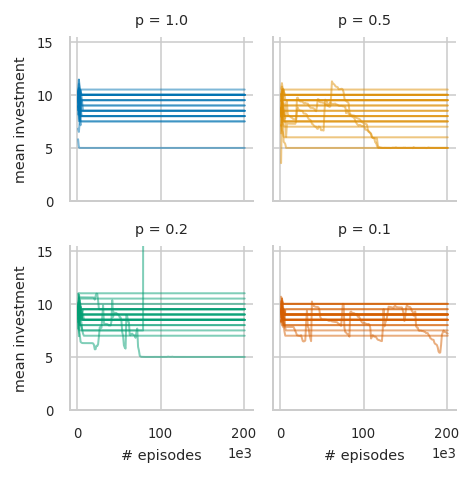

In [63]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/2, aspect=1, sharex=True, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv',
        estimator=None, alpha=0.5, linewidth=1, units="run")
#g.map_dataframe(sns.lineplot, x="episode_bin_right", y='custom_metrics/inv')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
    ax.set_ylim(0, 15.5)
g.set_axis_labels("# episodes", "mean investment")
g.tight_layout()
g.savefig(figdir + "inv_mean_details.pdf")

In [55]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/inv', hue="badsiteprob", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean inv per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "inv_mean_synth_step.pdf")

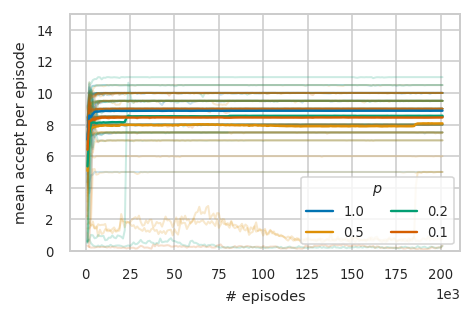

In [56]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept', hue="p", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# episodes')
plt.legend(title="$p$", ncol=2)
ax.ticklabel_format(axis="x", scilimits=(3, 3))
plt.tight_layout()
plt.savefig(figdir + "accept_mean_synth.pdf")

In [57]:
if step:
    plt.figure(figsize=figsize)

    sns.lineplot(data=alldf, x="step", y='custom_metrics/accept', hue="p", units="run", estimator=None)
    plt.ylim(0, 15)
    plt.ylabel('mean accept per episode')
    plt.xlabel('# steps')
    plt.legend(title="$p$")
    plt.tight_layout()
    plt.savefig(figdir + "accept_mean_step.pdf")

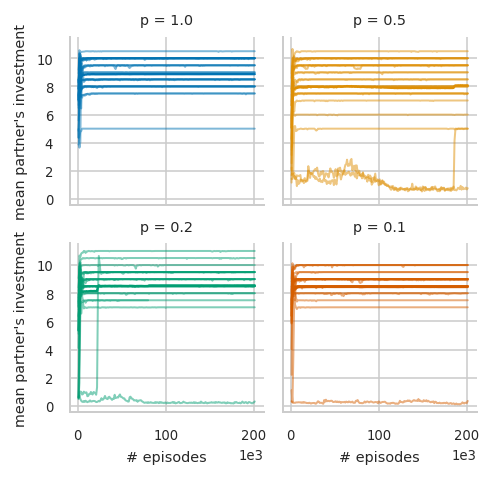

In [58]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
g.set_axis_labels("# episodes", "mean partner's investment")

plt.savefig(figdir + "accept_mean_detail.pdf")

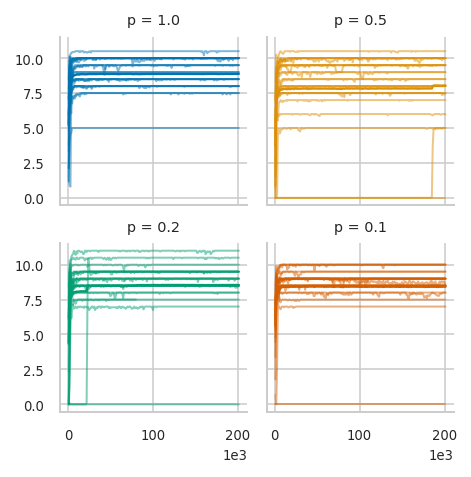

In [59]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='accept_min')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
plt.savefig(figdir + "accept_min_detail.pdf")

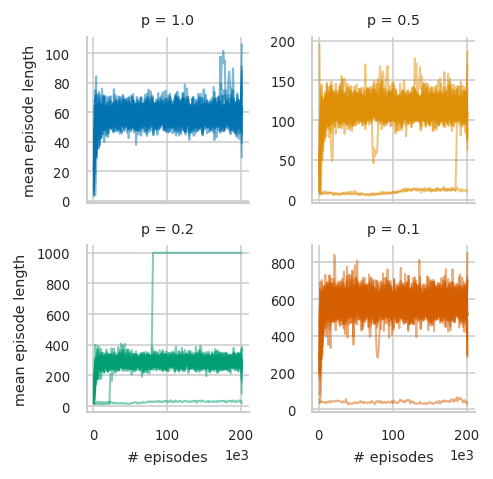

In [60]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=(figwidth/(1*2)), aspect=1, sharey=False, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='episode_len_mean')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
g.set_axis_labels("# episodes", "mean episode length")

plt.savefig(figdir + "episode_mean_detail.pdf")

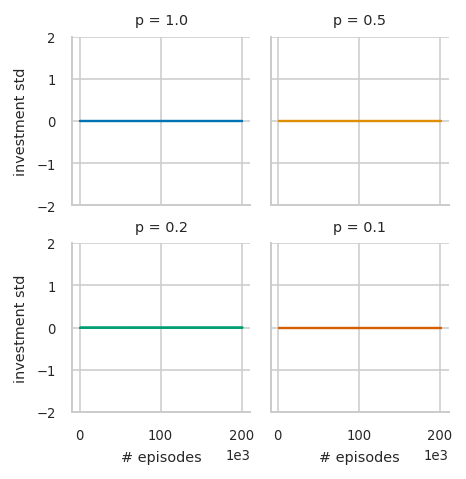

In [61]:
g = sns.FacetGrid(data=epcollapsed, col="p", col_wrap=2, height=figwidth/(1*2), aspect=1, hue="p")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std',
        estimator=None, alpha=0.5, linewidth=1, units="run")
g.map_dataframe(sns.lineplot, x="episode_bin_right", y='inv_std')
for ax in g.axes:
    ax.ticklabel_format(axis="x", scilimits=(3, 3))
g.tight_layout()
g.set(ylim=(-2, 2))
g.set_axis_labels("# episodes", "investment std")

plt.savefig(figdir + "inv_std_detail.pdf")